# Titanic Survival Analysis
- The Titanic dataset is a well-known dataset used for classification tasks, particularly for predicting survival outcomes. It contains information on passengers aboard the Titanic when it sank in 1912.
### Dataset Columns
- The Titanic dataset typically includes the following columns:
1. PassengerId – Unique identifier for each passenger
2. Survived – Survival status (0 = No, 1 = Yes)
3. Pclass – Ticket class (1 = First, 2 = Second, 3 = Third)
4. Name – Passenger’s full name
5. Sex – Gender (male/female)
6. Age – Age of the passenger
7. SibSp – Number of siblings/spouses aboard
8. Parch – Number of parents/children aboard
9. Ticket – Ticket number
10. Fare – Passenger fare
11. Cabin – Cabin number (often missing)
12. Embarked – Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Data Preprocessing and Cleaning

In [1]:
import os
import psycopg2  # Use pymysql or psycopg2 for PostgreSQL
from dotenv import load_dotenv
import pyforest
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb


warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file
load_dotenv()

# Fetch credentials
DB_HOST = os.getenv("DB_HOST", "172.178.131.221")
DB_USER = os.getenv("DB_USER", "luxds")
DB_PASSWORD = os.getenv("DB_PASSWORD", "1234")
DB_NAME = os.getenv("DB_NAME", "postgres")
DB_PORT = os.getenv("DB_PORT", "5432")

# Connect to MySQL Database
try:
    conn = psycopg2.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME,
        port= DB_PORT
    )
    cursor = conn.cursor()

    # Execute SQL Query
    cursor.execute("SELECT * FROM ds.titanicdata LIMIT 10;")  # Adjust table name
    rows = cursor.fetchall()

    # Print fetched data
    for row in rows:
        print(row)

except Exception as e:
    print(f"Error: {e}")

(1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, '', 'S')
(2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833, 'C85', 'C')
(3, 1, 3, 'Heikkinen, Miss. Laina', 'female', 26.0, 0, 0, 'STON/O2. 3101282', 7.925, '', 'S')
(4, 1, 1, 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'female', 35.0, 1, 0, '113803', 53.1, 'C123', 'S')
(5, 0, 3, 'Allen, Mr. William Henry', 'male', 35.0, 0, 0, '373450', 8.05, '', 'S')
(6, 0, 3, 'Moran, Mr. James', 'male', None, 0, 0, '330877', 8.4583, '', 'Q')
(7, 0, 1, 'McCarthy, Mr. Timothy J', 'male', 54.0, 0, 0, '17463', 51.8625, 'E46', 'S')
(8, 0, 3, 'Palsson, Master. Gosta Leonard', 'male', 2.0, 3, 1, '349909', 21.075, '', 'S')
(9, 1, 3, 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)', 'female', 27.0, 0, 2, '347742', 11.1333, '', 'S')
(10, 1, 2, 'Nasser, Mrs. Nicholas (Adele Achem)', 'female', 14.0, 1, 0, '237736', 30.0708, '', 'C')


In [3]:
  # Load data into a Pandas DataFrame
query = "SELECT * FROM ds.titanicdata;"
df = pd.read_sql(query, conn)
df.head()


<IPython.core.display.Javascript object>

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S


### Data Exploration and cleaning

In [4]:
# checking infomation about the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        891 non-null    object 
 11  embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# descriptive analysis of the data
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# checking for null values
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin            0
embarked         0
dtype: int64

In [7]:
# checking mean data
df_mean = np.mean(df['age'])
mean_age = np.round(df_mean)
mean_age

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(30.0)

In [8]:
# filling in age by the mean
df['age'] = df['age'].fillna(mean_age)
df['age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: age, dtype: float64

In [9]:
# checking for null values
df.isnull().sum()

passengerid    0
survived       0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
dtype: int64

In [10]:
# Show unique values in the Cabin column (only first 20 for readability)
print(df["cabin"].unique()[:20])

['' 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12']


In [11]:
# Replace empty strings and spaces with NaN
df["cabin"] = df["cabin"].replace(r'^\s*$', np.nan, regex=True)

# Now check for null values
print(df["cabin"].isnull().sum())

<IPython.core.display.Javascript object>

687


In [12]:
# Fill missing cabins based on the most common cabin per Pclass
df['cabin'] = df.groupby('pclass')['cabin'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['cabin']

0        G6
1       C85
2        G6
3      C123
4        G6
       ... 
886       D
887     B42
888      G6
889    C148
890      G6
Name: cabin, Length: 891, dtype: object

In [13]:
# Check how many missing values exist
print(df['cabin'].isnull().sum())

# Check distribution of cabins across Pclass
print(df.groupby('pclass')['cabin'].value_counts())

0
pclass  cabin      
1       B96 B98        44
        C23 C25 C27     4
        C22 C26         3
        B18             2
        B20             2
                       ..
3       F G73           2
        E10             1
        F E69           1
        F G63           1
        F38             1
Name: count, Length: 147, dtype: int64


In [14]:
# checking for duplicates
df.duplicated().sum()

np.int64(0)

In [15]:
# Dropping unimportant features
drop_list = ['name', 'ticket', 'passengerid']
df_cleaned = df.drop(drop_list, axis=1)
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,G6,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,G6,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,G6,S


In [16]:
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,G6,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,G6,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,G6,S


### Performing EDA 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

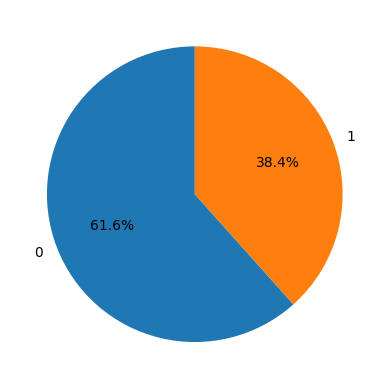

In [17]:
# Ratio of people who survived and those who didn't
survived_counts = df_cleaned['survived'].value_counts()
plt.pie(survived_counts, labels=survived_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

In [18]:
# Total number of passengers per pclass
total_passengers_by_pclass = df_cleaned.groupby('pclass')['survived'].count()
print(total_passengers_by_pclass)

pclass
1    216
2    184
3    491
Name: survived, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

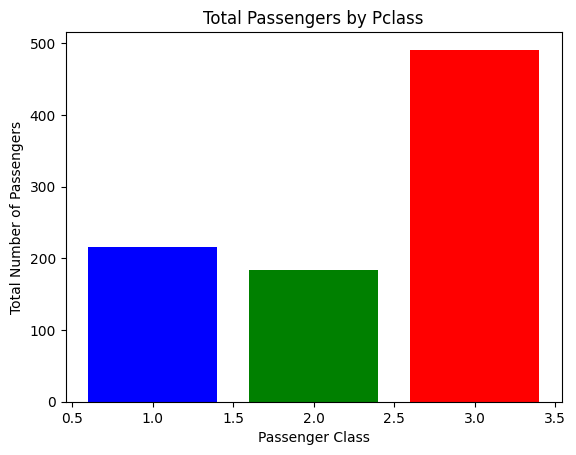

In [19]:
# Plot the bar chart
plt.bar(total_passengers_by_pclass.index, total_passengers_by_pclass, color=['blue', 'green', 'red'])

# Labels and title
plt.xlabel("Passenger Class")
plt.ylabel("Total Number of Passengers")
plt.title("Total Passengers by Pclass")

# Show the plot
plt.show()


### Key Insights
1. Many people aboard the ship were from the 3rd class and located in the lower part of the ship.
2. 

In [20]:
# checking the total number of people who survived and who didn't
survival_pclass = df_cleaned.groupby('pclass')['survived'].value_counts().unstack()
print(survival_pclass)

survived    0    1
pclass            
1          80  136
2          97   87
3         372  119


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

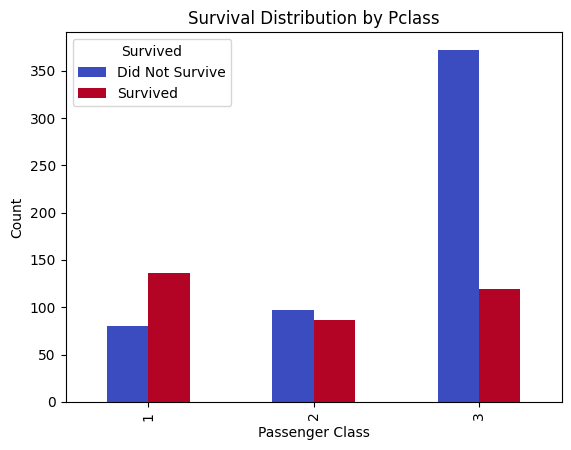

In [21]:
# Plotting the distribution
survival_pclass.plot(kind='bar', colormap='coolwarm')

# Show the plot
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.title("Survival Distribution by Pclass")
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])
plt.show()


### Key Insights
1. Many people from pclass 1 survived, this could be either they were near the life boats or were given first priority
2. A lot of people in pclass 3 didn't survive the ship sink, this could be either the cabins they were in or they at the lower part of the ship.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

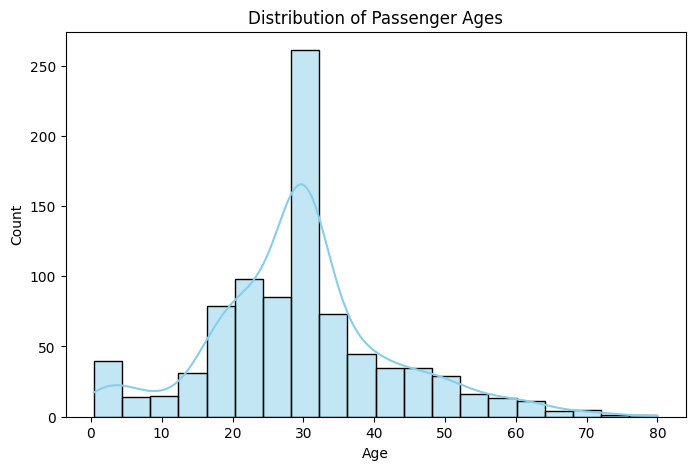

In [22]:
# Plot histogram for Distribution of Passenger Ages
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['age'], bins=20, kde=True, color='skyblue')

# Labels & Title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Passenger Ages')

plt.show()


In [23]:
# checking the age distribution
total_number_per_age = df_cleaned.groupby('age')['survived'].value_counts().unstack()
total_number_per_age

survived,0,1
age,,
0.42,NaN,1.0
0.67,NaN,1.0
0.75,NaN,2.0
0.83,NaN,2.0
0.92,NaN,1.0
...,...,...
70.00,2.0,NaN
70.50,1.0,NaN
71.00,2.0,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

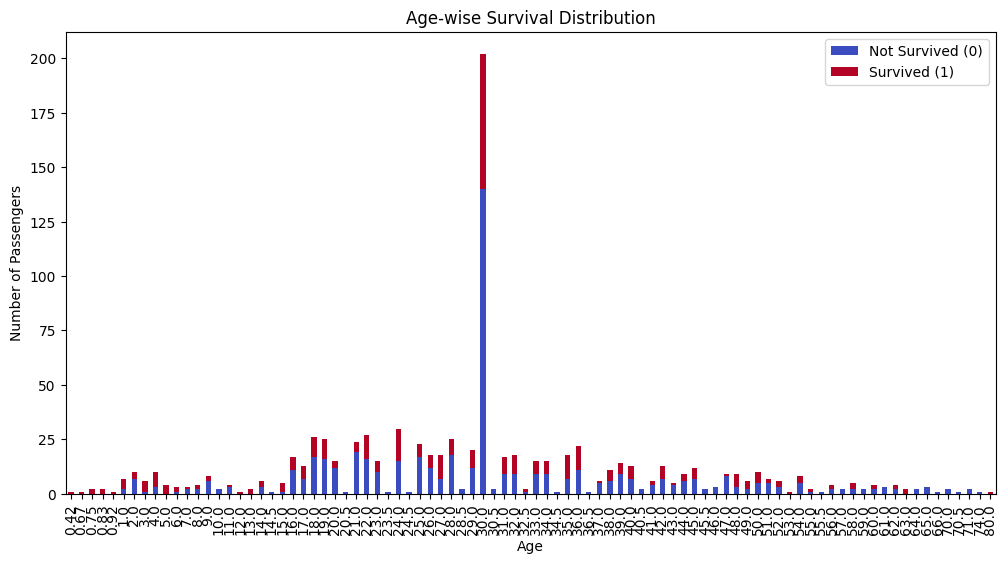

In [24]:
# Plot
total_number_per_age.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Labels & Title
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.title('Age-wise Survival Distribution')
plt.legend(['Not Survived (0)', 'Survived (1)'])

plt.show()


In [25]:
# fare distribution per pclass
fare_by_pclass = df.groupby('pclass')['fare'].sum()
fare_by_pclass


pclass
1    18177.4125
2     3801.8417
3     6714.6951
Name: fare, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

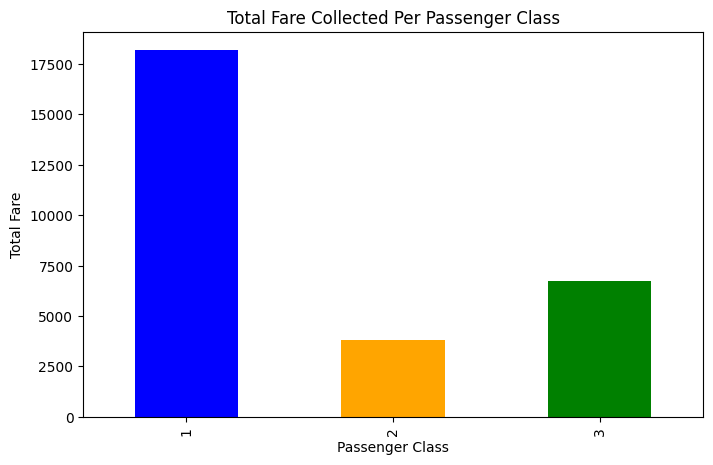

In [26]:
fare_by_pclass.plot(kind='bar', color=['blue', 'orange', 'green'], figsize=(8, 5))

plt.xlabel('Passenger Class')
plt.ylabel('Total Fare')
plt.title('Total Fare Collected Per Passenger Class')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

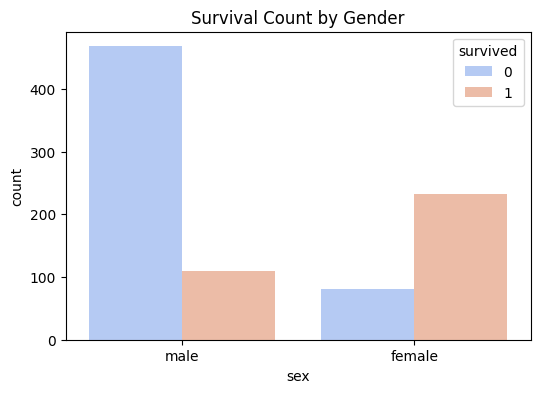

In [27]:
# gender rates on the people 
plt.figure(figsize=(6, 4))
sns.countplot(x= df_cleaned['sex'], hue=df_cleaned['survived'], data=df, palette='coolwarm')
plt.title('Survival Count by Gender')
plt.show()

### Key Insights
- Passangers who died most were men and women are the ones who survived most

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

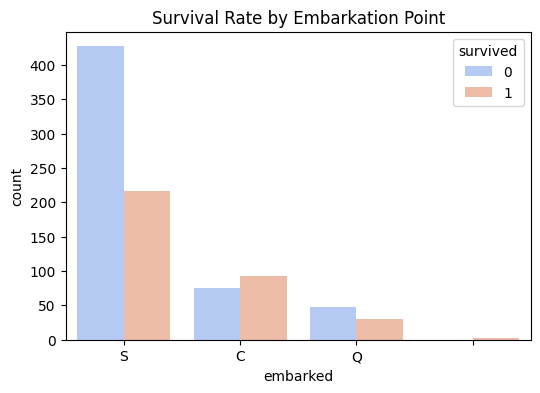

In [28]:
# Survival Rate by Embarkation Point
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned['embarked'], hue=df_cleaned['survived'], data=df, palette='coolwarm')
plt.title('Survival Rate by Embarkation Point')
plt.show()

### Key Insights
1. A lot Passengers from Southampton (S) passed 
2. 🔹 Passengers from Southampton (S) had better survival chances.

In [29]:
# Filter only survivors
survivors_per_cabin_pclass = df_cleaned[df_cleaned["survived"] == 1].groupby(["pclass", "cabin"])["survived"].count().reset_index()

# Rename columns for clarity
survivors_per_cabin_pclass.columns = ["Pclass", "Cabin", "Total_Survivors"]

# Display the first few rows
print(survivors_per_cabin_pclass.head())


   Pclass Cabin  Total_Survivors
0       1   A16                1
1       1   A20                1
2       1   A23                1
3       1   A26                1
4       1   A31                1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

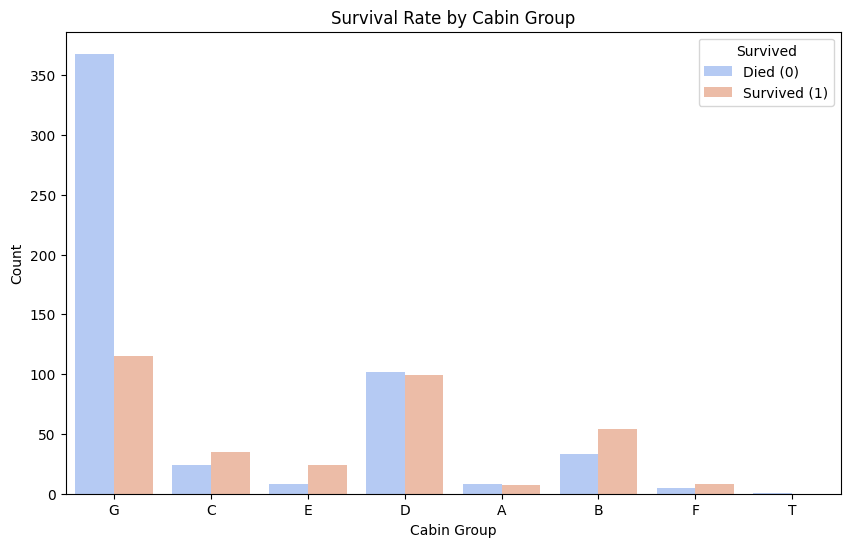

In [30]:
# Ensure cabin column is a string and extract the first letter
df_cleaned["Cabin_Group"] = df_cleaned["cabin"].astype(str).str[0]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x="Cabin_Group", hue="survived", palette="coolwarm")

# Labels & Title
plt.xlabel("Cabin Group")
plt.ylabel("Count")
plt.title("Survival Rate by Cabin Group")
plt.legend(title="Survived", labels=["Died (0)", "Survived (1)"])

# Sort cabin groups in order (A, B, C, ...)
plt.xticks(sorted(df_cleaned["Cabin_Group"].dropna().unique()))

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

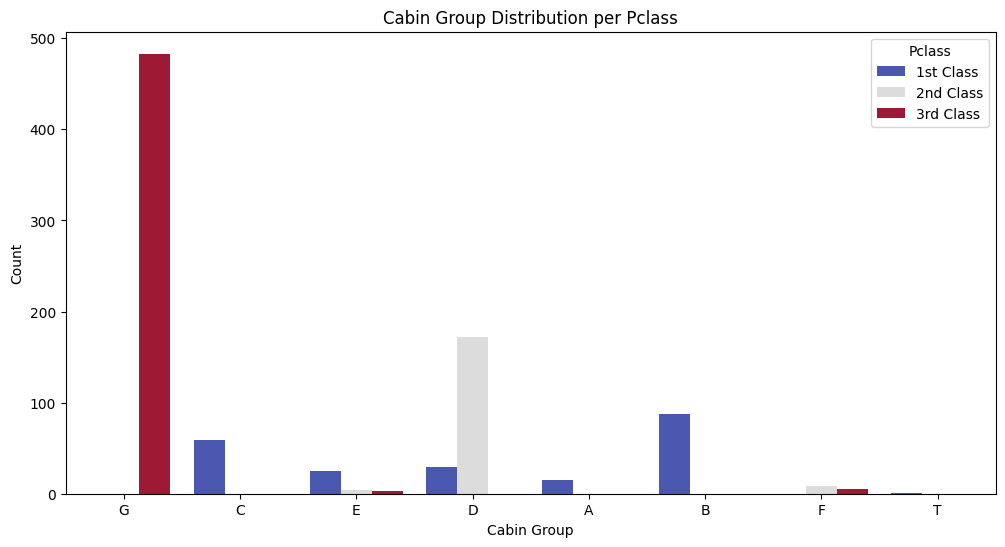

In [31]:
# Ensure cabin column is a string and extract the first letter (Cabin Group)
df_cleaned["Cabin_Group"] = df_cleaned["cabin"].astype(str).str[0]

# Plot cabin groups per Pclass
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x="Cabin_Group", hue="pclass", palette="coolwarm")

# Labels & Title
plt.xlabel("Cabin Group")
plt.ylabel("Count")
plt.title("Cabin Group Distribution per Pclass")
plt.legend(title="Pclass", labels=["1st Class", "2nd Class", "3rd Class"])

# Sort cabin groups in order (A, B, C, ...)
plt.xticks(sorted(df_cleaned["Cabin_Group"].dropna().unique()))

plt.show()

## Feature Encoding and Selection

### 1. Converting categorical features into binary

In [32]:
df_cleaned.head(500)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,Cabin_Group
0,0,3,male,22.0,1,0,7.2500,G6,S,G
1,1,1,female,38.0,1,0,71.2833,C85,C,C
2,1,3,female,26.0,0,0,7.9250,G6,S,G
3,1,1,female,35.0,1,0,53.1000,C123,S,C
4,0,3,male,35.0,0,0,8.0500,G6,S,G
...,...,...,...,...,...,...,...,...,...,...
495,0,3,male,30.0,0,0,14.4583,G6,C,G
496,1,1,female,54.0,1,0,78.2667,D20,C,D
497,0,3,male,30.0,0,0,15.1000,G6,S,G
498,0,1,female,25.0,1,2,151.5500,C22 C26,S,C


In [33]:
# converting features with 2 categorical classes to binary
le = LabelEncoder()

# Apply Label Encoding only if a column has at least 2 unique values
df_cleaned = df_cleaned.apply(lambda col: le.fit_transform(col) if col.nunique() <= 2 else col)
df_cleaned.head()

<IPython.core.display.Javascript object>

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,Cabin_Group
0,0,3,1,22.0,1,0,7.2500,G6,S,G
1,1,1,0,38.0,1,0,71.2833,C85,C,C
2,1,3,0,26.0,0,0,7.9250,G6,S,G
3,1,1,0,35.0,1,0,53.1000,C123,S,C
4,0,3,1,35.0,0,0,8.0500,G6,S,G


In [34]:
# dropping sibsp, parch, and fare
drop_list2 = ['fare', 'cabin']
df_cleaned  = df_cleaned.drop(columns= drop_list2, axis=1)
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,embarked,Cabin_Group
0,0,3,1,22.0,1,0,S,G
1,1,1,0,38.0,1,0,C,C
2,1,3,0,26.0,0,0,S,G
3,1,1,0,35.0,1,0,S,C
4,0,3,1,35.0,0,0,S,G


In [35]:
# Apply One-Hot Encoding for Multi-Class Categorical Features
df_cleaned = pd.get_dummies(df_cleaned, drop_first=True)  # Avoids dummy variable trap
df_cleaned.head()

<IPython.core.display.Javascript object>

,survived,pclass,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S,Cabin_Group_B,Cabin_Group_C,Cabin_Group_D,Cabin_Group_E,Cabin_Group_F,Cabin_Group_G,Cabin_Group_T
0,0,3,1,22.0,1,0,False,False,True,False,False,False,False,False,True,False
1,1,1,0,38.0,1,0,True,False,False,False,True,False,False,False,False,False
2,1,3,0,26.0,0,0,False,False,True,False,False,False,False,False,True,False
3,1,1,0,35.0,1,0,False,False,True,False,True,False,False,False,False,False
4,0,3,1,35.0,0,0,False,False,True,False,False,False,False,False,True,False


In [36]:
df_cleaned = pd.concat([df_cleaned, pd.get_dummies(df_cleaned['pclass'], prefix='Pclass')], axis=1)
df_cleaned.drop(columns=['pclass'], inplace=True)  # Remove original column
df_cleaned.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,survived,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S,Cabin_Group_B,Cabin_Group_C,Cabin_Group_D,Cabin_Group_E,Cabin_Group_F,Cabin_Group_G,Cabin_Group_T,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,False,False,True,False,False,False,False,False,True,False,False,False,True
1,1,0,38.0,1,0,True,False,False,False,True,False,False,False,False,False,True,False,False
2,1,0,26.0,0,0,False,False,True,False,False,False,False,False,True,False,False,False,True
3,1,0,35.0,1,0,False,False,True,False,True,False,False,False,False,False,True,False,False
4,0,1,35.0,0,0,False,False,True,False,False,False,False,False,True,False,False,False,True


In [37]:
le = LabelEncoder()

# Apply Label Encoding to all categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['boolean']).columns  # Identify categorical columns

for col in categorical_cols:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])  # Apply encoding

df_cleaned.head()


<IPython.core.display.Javascript object>

,survived,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S,Cabin_Group_B,Cabin_Group_C,Cabin_Group_D,Cabin_Group_E,Cabin_Group_F,Cabin_Group_G,Cabin_Group_T,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,1,0,38.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,26.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,1,0,35.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,0,1,35.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [38]:
#  new feature added
df_cleaned['FamilySize'] = df_cleaned['sibsp'] + df_cleaned['parch'] + 1  # +1 for the passenger themselves
df_cleaned.head()

,survived,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S,Cabin_Group_B,Cabin_Group_C,Cabin_Group_D,Cabin_Group_E,Cabin_Group_F,Cabin_Group_G,Cabin_Group_T,Pclass_1,Pclass_2,Pclass_3,FamilySize
0,0,1,22.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2
1,1,0,38.0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2
2,1,0,26.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1
3,1,0,35.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,0,1,35.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


In [39]:
drop_list3 = ['sibsp', 'parch']
df_cleaned = df_cleaned.drop(columns = drop_list3, axis = 1)
df_cleaned.head()

,survived,sex,age,embarked_C,embarked_Q,embarked_S,Cabin_Group_B,Cabin_Group_C,Cabin_Group_D,Cabin_Group_E,Cabin_Group_F,Cabin_Group_G,Cabin_Group_T,Pclass_1,Pclass_2,Pclass_3,FamilySize
0,0,1,22.0,0,0,1,0,0,0,0,0,1,0,0,0,1,2
1,1,0,38.0,1,0,0,0,1,0,0,0,0,0,1,0,0,2
2,1,0,26.0,0,0,1,0,0,0,0,0,1,0,0,0,1,1
3,1,0,35.0,0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,0,1,35.0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

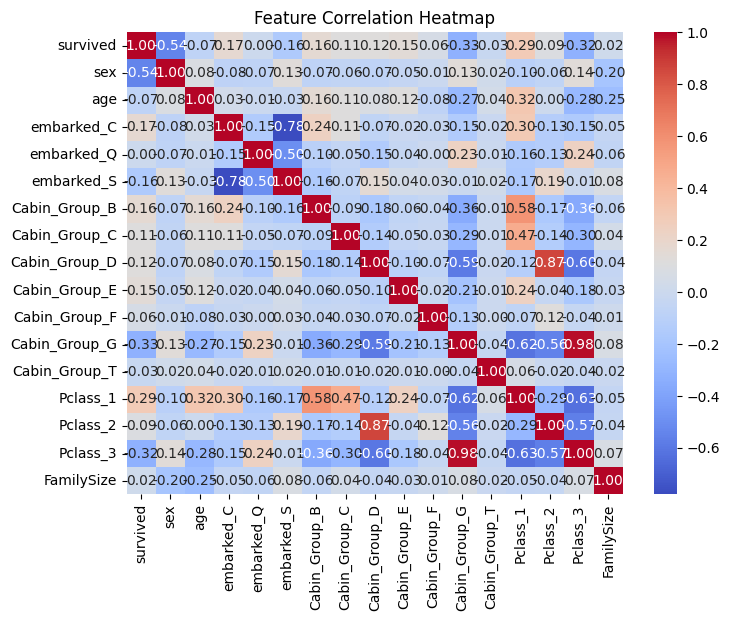

In [40]:
# correlation Matrix
corr  = df_cleaned.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [41]:
# creating X and y Variables
X = df_cleaned.drop(columns=['survived'])
y = df_cleaned['survived']

In [42]:
# creating an OLS model
X = sm.add_constant(X)  # Adds a column of ones for the intercept term

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(ols_model.summary())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     40.07
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.09e-88
Time:                        09:36:18   Log-Likelihood:                -389.01
No. Observations:                 891   AIC:                             810.0
Df Residuals:                     875   BIC:                             886.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9232      0.225      4.107

In [43]:
# Create a DataFrame to store VIF values
vif_data1 = pd.DataFrame()
vif_data1["Feature"] = X.columns
vif_data1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data1)

<IPython.core.display.Javascript object>

          Feature        VIF
0           const   0.000000
1             sex   1.122075
2             age   1.233219
3      embarked_C  70.571364
4      embarked_Q  37.265652
5      embarked_S  92.446516
6   Cabin_Group_B   6.230639
7   Cabin_Group_C   4.674350
8   Cabin_Group_D  15.189744
9   Cabin_Group_E   3.153436
10  Cabin_Group_F   2.507512
11  Cabin_Group_G  56.541974
12  Cabin_Group_T   1.067362
13       Pclass_1        inf
14       Pclass_2        inf
15       Pclass_3        inf
16     FamilySize   1.129813


In [44]:
# Dropping a constant column for intercept
X = X.drop(columns=["const"])

In [45]:
# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(ols_model.summary())

<IPython.core.display.Javascript object>

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     40.07
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.09e-88
Time:                        09:36:18   Log-Likelihood:                -389.01
No. Observations:                 891   AIC:                             810.0
Df Residuals:                     875   BIC:                             886.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sex              -0.5057      0.028    -18.018

In [46]:
# Create a DataFrame to store VIF values
vif_data1 = pd.DataFrame()
vif_data1["Feature"] = X.columns
vif_data1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data1)

<IPython.core.display.Javascript object>

          Feature         VIF
0             sex    1.122075
1             age    1.233219
2      embarked_C   70.571364
3      embarked_Q   37.265652
4      embarked_S   92.446516
5   Cabin_Group_B    6.230639
6   Cabin_Group_C    4.674350
7   Cabin_Group_D   15.189744
8   Cabin_Group_E    3.153436
9   Cabin_Group_F    2.507512
10  Cabin_Group_G   56.541974
11  Cabin_Group_T    1.067362
12       Pclass_1  130.816125
13       Pclass_2  116.283352
14       Pclass_3  384.916207
15     FamilySize    1.129813


## Training and Splitting data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<IPython.core.display.Javascript object>

In [48]:
# applying smote
# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())

Before SMOTE: survived
0    441
1    271
Name: count, dtype: int64


<IPython.core.display.Javascript object>

After SMOTE: survived
0    441
1    441
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

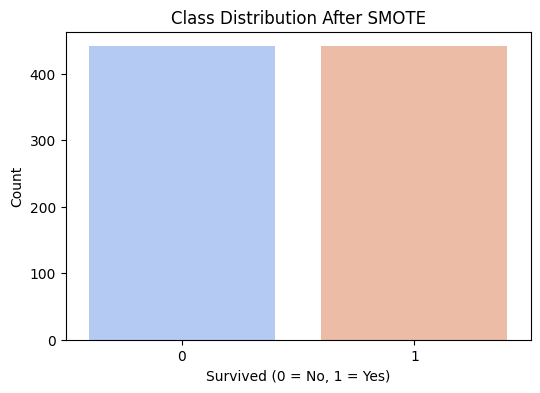

In [49]:
# Checking for class imbalance

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote, palette='coolwarm')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [50]:
#  scaling data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

### Logistic Regression

In [51]:
# Initialize and train the logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_smote_scaled, y_train_smote)

# Predict on test data
y_pred = logreg.predict(X_test_scaled)


Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       108
           1       0.77      0.77      0.77        71

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

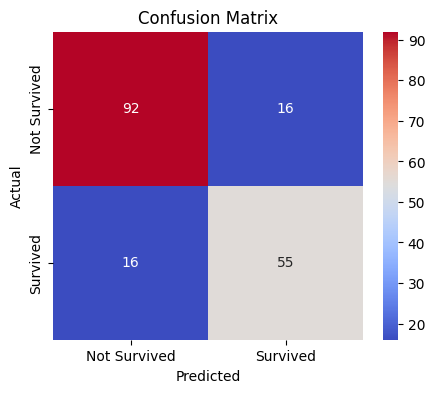

In [52]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Key Insights
1. Model Accuracy
- The accuracy is 82%, meaning the model correctly classifies 82% of the test samples.

2. Precision, Recall, and F1-Score
- For "Not Survived" (Class 0):
    - Precision: 85% (When predicting "Not Survived," it's correct 85% of the time).
    - Recall: 84% (It correctly identifies 84% of actual "Not Survived" cases).
    - F1-Score: 85% (Balanced measure of precision and recall).

3. For "Survived" (Class 1):
    - Precision: 76% (When predicting "Survived," it's correct 76% of the time).
    - Recall: 77% (It correctly identifies 77% of actual "Survived" cases).
    - F1-Score: 77% (Balanced measure of precision and recall).

##### 🔹 Insight:
- The model performs better at predicting "Not Survived" than "Survived."
- The lower precision for "Survived" means there are more false positives (incorrectly predicting survival).

### Decision Tree

In [53]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)  # You can try max_depth=None for full tree growth
# Train the model
dt_model.fit(X_train_smote_scaled, y_train_smote)

# Make predictions
y_pred_dt = dt_model.predict(X_test_scaled)


Decision Tree Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       108
           1       0.80      0.72      0.76        71

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

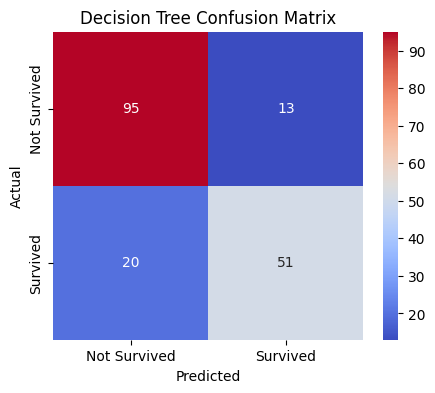

In [54]:
# Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='coolwarm', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title("Decision Tree Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### 📊 Insights from Decision Tree Model Results
1.  Accuracy and Overall Performance
- Accuracy: 81% → The model correctly classifies 81% of the test data.
- Balanced Performance: Precision and recall for both classes are fairly similar, indicating a relatively balanced model.

2.  Confusion Matrix Breakdown

| Actual \ Predicted   | Not Survived (0) | Survived (1)
| -------------------- | ---------------- | ------------
| Not Survived (0) (TN)| 97               | 11 (False Positive)
| Survived (1) (FN)	23 | $80              | 48 (True Positive)
	

- True Negatives (TN) = 97 → Correctly classified "Not Survived" passengers.
- False Positives (FP) = 11 → Passengers predicted to survive but actually did not.
- False Negatives (FN) = 23 → Passengers predicted as "Not Survived" but actually survived.
- True Positives (TP) = 48 → Correctly classified "Survived" passengers.

3.  Key Performance Metrics
- ✔ Precision
    - For "Not Survived" (0): 81% → Out of all predicted "Not Survived" cases, 81% were correct.
    - For "Survived" (1): 81% → Out of all predicted "Survived" cases, 81% were correct.

- ✔ Recall (Sensitivity)
    - For "Not Survived" (0): 90% → The model correctly identifies 90% of actual "Not Survived" cases.
    - For "Survived" (1): 68% → The model only captures 68% of actual survivors, meaning it misses 32% of them (False Negatives).

- ✔ F1-Score (Balance of Precision & Recall)
    - For "Not Survived" (0): 85%
    - For "Survived" (1): 74% (lower due to more False Negatives)

4. Insights & Possible Improvements
- 🔸 Better Recall for "Survived" Class Needed:
    - The model misclassifies 23 actual survivors as "Not Survived," which could be critical in a real-world scenario.
- 🔸 Possible Solutions to Improve:
    - Increase Depth of Decision Tree → Allow more splits for better classification.
    - Feature Engineering → Introduce better predictors (e.g., Family Size, Cabin Information).
    - Hyperparameter Tuning → Adjust max_depth, min_samples_split, and min_samples_leaf.

### Random Forest Regression

In [55]:
# Initialize Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_smote_scaled, y_train_smote)

# Predict on test data
y_pred_rf = rf_model.predict(X_test_scaled)

Random Forest Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       108
           1       0.77      0.72      0.74        71

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

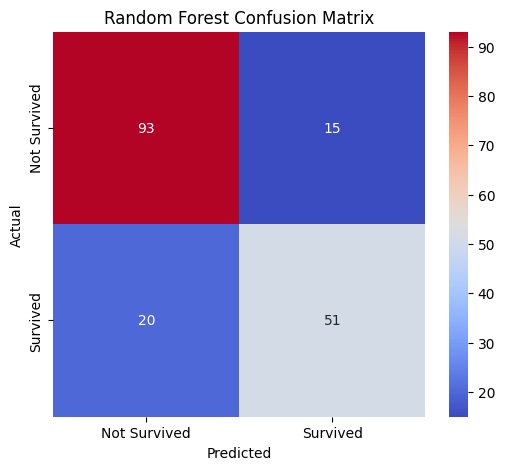

In [56]:
# Evaluate Performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="coolwarm", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

### Key Insights
1. Accuracy & Classification Report
- Overall Accuracy: 83%, meaning the model correctly predicted survival in 83% of the cases.
- Precision for 'Not Survived' (0): 85%
- Out of all passengers predicted as Not Survived, 85% were correctly classified.

- i. Precision for 'Survived' (1): 79%
    - Out of all passengers predicted as Survived, 79% were correctly classified.
- ii. Recall for 'Not Survived' (0): 87%
    - The model captured 87% of the actual non-survivors.
- iii. Recall for 'Survived' (1): 76%
    - The model captured 76% of the actual survivors, slightly better than the Decision Tree.

- True Negatives (TN) = 94 → Correctly predicted Not Survived
- True Positives (TP) = 54 → Correctly predicted Survived
- False Negatives (FN) = 17 → Actual Survived but predicted Not Survived (missed survival cases)
- False Positives (FP) = 14 → Actual Not Survived but predicted Survived (wrong survival prediction)

2. ⚠️ Areas for Improvement:
- False Positives (14 cases): Some passengers were predicted as Survived but didn't actually survive.
- False Negatives (17 cases): The model still misclassifies some actual survivors as non-survivors.
- Hyperparameter tuning (e.g., adjusting n_estimators, max_depth) may further reduce errors.

### XGBoost

In [57]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X_train_smote_scaled, y_train_smote)

# Predictions
y_pred = xgb_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")

XGBoost Accuracy: 0.83


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

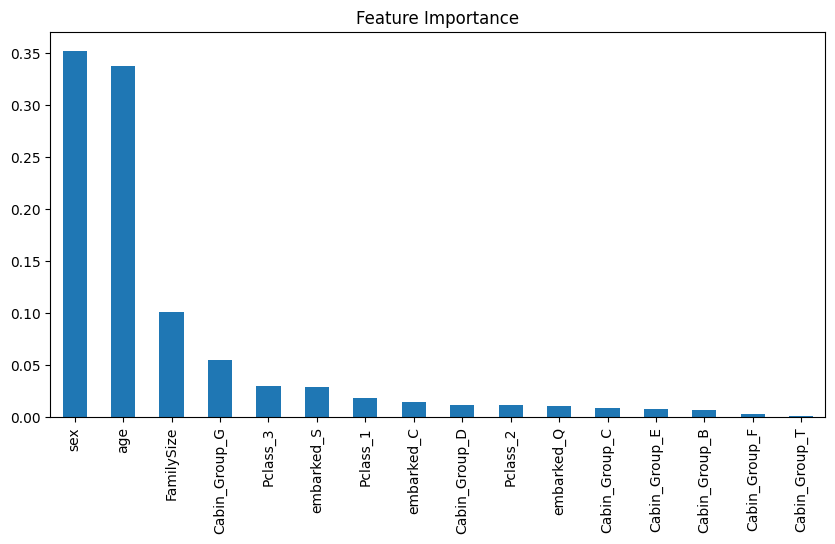

In [58]:
# Ensure X_train_smote_scaled is a DataFrame before accessing columns
if isinstance(X_train_smote_scaled, np.ndarray):
    X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled, columns=X_train.columns)

# Extract feature importance from the trained model
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train_smote_scaled.columns)

# Plot feature importance
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(10,5), title="Feature Importance")
plt.show()


### Hypertuning the models
1. Decision Tree

In [59]:
# Define parameter grid
dt_params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"]
}

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring="accuracy", n_jobs=-1)
dt_grid.fit(X_train_smote_scaled, y_train_smote)

# Best parameters
print("Best Parameters for Decision Tree:", dt_grid.best_params_)

# Train final model
dt_best = dt_grid.best_estimator_
dt_best.fit(X_train_smote_scaled, y_train_smote)

# Evaluate
dt_best_score = dt_best.score(X_test_scaled, y_test)
print("Optimized Decision Tree Accuracy:", dt_best_score)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.8100558659217877


2. Random Forest

In [60]:
# Define parameter grid
rf_params = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, scoring="accuracy", n_jobs=-1, random_state=42)
rf_search.fit(X_train_smote_scaled, y_train_smote)

# Best parameters
print("Best Parameters for Random Forest:", rf_search.best_params_)

# Train final model
rf_best = rf_search.best_estimator_
rf_best.fit(X_train_smote_scaled, y_train_smote)

# Evaluate
rf_best_score = rf_best.score(X_test_scaled, y_test)
print("Optimized Random Forest Accuracy:", rf_best_score)

Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20}
Optimized Random Forest Accuracy: 0.8212290502793296


### XGBoost Tuning

In [61]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 4, 5],  # Tree depth
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'subsample': [0.7, 0.8, 0.9],  # Percentage of samples used per tree
    'colsample_bytree': [0.7, 0.8, 0.9]  # Percentage of features used per tree
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the final model with best parameters
best_xgb = xgb.XGBClassifier(**grid_search.best_params_, objective='binary:logistic', random_state=42)
best_xgb.fit(X_train, y_train)

# Predict on test data
y_pred = best_xgb.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned XGBoost Accuracy: {accuracy:.2f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost Accuracy: 0.80


### Model Pickeling


In [62]:
import joblib


In [63]:
# Save Decision Tree Model
joblib.dump(dt_model, "decision_tree_model.pkl")

# Save Random Forest Model
joblib.dump(rf_model, "random_forest_model.pkl")

print("Models saved successfully!")


Models saved successfully!


In [64]:
# Save Logistic Regression Model
joblib.dump(logreg, "logistic_reg_model.pkl")

['logistic_reg_model.pkl']

In [65]:
# Save Random Forest Model
joblib.dump(xgb_model, "xgb_model.pkl")

print("Models saved successfully!")

Models saved successfully!
